# Anomaly Detection with AutoEncoder (pytorch)
Hi! I'm new to kaggle, and this is my first competition in my life. 
If you notice the better way about my implementation please tell me! :)

In past fraud detection competition, some people used auto encoder approach to detect anomalous for fraud data.
There are categorical variables in the case, however, I thought the same approach can be applied to the task.
So I just tried it.

TODO:
- Current implementation is incorrect. training should be done by using only non fraud data.

https://www.kaggle.com/jdoz22/detecting-fraud-using-an-autoencoder-and-pytorch?scriptVersionId=2802227
https://www.kaggle.com/artgor/eda-and-models/notebook

In [2]:
pip install xgboost

     |████████████████████████████████| 1.2 MB 614 kB/s eta 0:00:01
You should consider upgrading via the '/Users/nicenoize/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os

import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
#import xgboost as xgb
import seaborn as sns
import collections

from tqdm import tqdm, tqdm_notebook


from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score)
from sklearn.metrics import accuracy_score, precision_score
                            
import torch.nn as nn
from torch.autograd import Variable as V
import torch.nn.functional as F
import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
%matplotlib inline
from bokeh.plotting import figure, output_notebook, show, ColumnDataSource
from bokeh.models import HoverTool, NumeralTickFormatter
from bokeh.palettes import Set3_12
from bokeh.transform import jitter

import gc
gc.enable()

In [5]:
# Training epochs
epochs=10

# Preprocessing

In [16]:
train_transaction = pd.read_csv('patient_vecs.csv', index_col='SUBJECT_ID')
test_transaction = pd.read_csv('patient_vecs.csv', index_col='SUBJECT_ID')

train_identity = pd.read_csv('patient_vecs.csv', index_col='SUBJECT_ID')
test_identity = pd.read_csv('patient_vecs.csv', index_col='SUBJECT_ID')

sample_submission = pd.read_csv('patient_vecs.csv', index_col='SUBJECT_ID')

train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)

print(train.shape)
print(test.shape)

(39363, 18)
(39363, 18)


In [7]:
train.head()

,GENDER_x,EXPIRE_FLAG_x,ETHNICITY_x,DIAGNOSIS_x,HAS_CHARTEVENTS_DATA_x,DRUG_x,FORMULARY_DRUG_CD_x,age_x,ICD9_CODE_x,GENDER_y,EXPIRE_FLAG_y,ETHNICITY_y,DIAGNOSIS_y,HAS_CHARTEVENTS_DATA_y,DRUG_y,FORMULARY_DRUG_CD_y,age_y,ICD9_CODE_y
SUBJECT_ID,,,,,,,,,,,,,,,,,,
2,['M'],[0],['ASIAN'],['NEWBORN'],[1],"['NEO*IV*Gentamicin', 'Syringe (Neonatal) *D5W...","['GENT10I', 'NEOSYRD5W', 'AMP500I', 'AMPVL']",[0],"['V3001', 'V053', 'V290']",['M'],[0],['ASIAN'],['NEWBORN'],[1],"['NEO*IV*Gentamicin', 'Syringe (Neonatal) *D5W...","['GENT10I', 'NEOSYRD5W', 'AMP500I', 'AMPVL']",[0],"['V3001', 'V053', 'V290']"
4,['F'],[0],['WHITE'],"['FEVER,DEHYDRATION,FAILURE TO THRIVE']",[1],"['Iso-Osmotic Dextrose', 'Insulin', 'Benzonata...","['VANCOBASE', 'GLAR100I', 'BENZ100', 'INSULIN'...",[47],"['042', '1363', '7994', '2763', '7907', '5715'...",['F'],[0],['WHITE'],"['FEVER,DEHYDRATION,FAILURE TO THRIVE']",[1],"['Iso-Osmotic Dextrose', 'Insulin', 'Benzonata...","['VANCOBASE', 'GLAR100I', 'BENZ100', 'INSULIN'...",[47],"['042', '1363', '7994', '2763', '7907', '5715'..."
6,['F'],[0],['WHITE'],['CHRONIC RENAL FAILURE/SDA'],[1],"['Tacrolimus', 'Warfarin', 'Heparin Sodium', '...","['TACR1', 'WARF5', 'HEPAPREMIX', 'HEPBASE', 'F...",[65],"['40391', '4440', '9972', '2766', '2767', '285...",['F'],[0],['WHITE'],['CHRONIC RENAL FAILURE/SDA'],[1],"['Tacrolimus', 'Warfarin', 'Heparin Sodium', '...","['TACR1', 'WARF5', 'HEPAPREMIX', 'HEPBASE', 'F...",[65],"['40391', '4440', '9972', '2766', '2767', '285..."
8,['M'],[0],['WHITE'],['NEWBORN'],[1],"['Send 500mg Vial', 'NEO*IV*Gentamicin', 'NEO*...","['AMPVL', 'GENT10I', 'NAMP500I', 'NEOSYRD5W']",[0],"['V3001', '7706', '7746', 'V290', 'V502', 'V053']",['M'],[0],['WHITE'],['NEWBORN'],[1],"['Send 500mg Vial', 'NEO*IV*Gentamicin', 'NEO*...","['AMPVL', 'GENT10I', 'NAMP500I', 'NEOSYRD5W']",[0],"['V3001', '7706', '7746', 'V290', 'V502', 'V053']"
9,['M'],[1],['UNKNOWN/NOT SPECIFIED'],['HEMORRHAGIC CVA'],[1],"['SW', 'Labetalol HCl', 'Potassium Chloride', ...","['KCLBASE', 'LABE100I', 'KCL20P', 'D5W250', 'N...",[41],"['431', '5070', '4280', '5849', '2765', '4019']",['M'],[1],['UNKNOWN/NOT SPECIFIED'],['HEMORRHAGIC CVA'],[1],"['SW', 'Labetalol HCl', 'Potassium Chloride', ...","['KCLBASE', 'LABE100I', 'KCL20P', 'D5W250', 'N...",[41],"['431', '5070', '4280', '5849', '2765', '4019']"


## Drop columns and Standard Scaling

In [ ]:
# Drop columns
def dropper(column_name, train, test):
    train = train.drop(column_name, axis=1)
    test = test.drop(column_name, axis=1)
    return train, test

del_columns = ['TransactionDT']
for col in del_columns:
    train, test = dropper(col, train, test)

def scaler(scl, column_name, data):
    data[column_name] = scl.fit_transform(data[column_name].values.reshape(-1,1))
    return data

scl_columns = ['TransactionAmt', 'card1', 'card3', 'card5', 'addr1', 'addr2']
for col in scl_columns:
    train = scaler(StandardScaler(), col, train)
    test = scaler(StandardScaler(), col, test)

In [ ]:
train.head()

In [ ]:
"""
#TODO: Learning should be done by using non fraud data
train = train[train['isFraud'] == 0]
train_fraud = train[train['isFraud'] == 1].copy()
"""

# AutoEncoder
## Preprocessing

In [18]:
y_train = train.copy()
#del train_transaction, train_identity, test_transaction, test_identity

# Drop target
X_train = train
#X_train_fraud = train_fraud.drop('isFraud', axis=1)
X_test = test.copy()

del train, test
    
# TODO: change methods
# Fill in NaNs
X_train = X_train.fillna(-999)
#X_train_fraud = X_train_fraud.fillna(-999)
X_test = X_test.fillna(-999)

# TODO: change to Label Count Endocing
# Label Encoding
for f in X_train.columns:
    if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values) + list(X_test[f].values)) #+ list(X_train_fraud[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
        #X_train_fraud[f] = lbl.transform(list(X_train_fraud[f].values)) 
        X_test[f] = lbl.transform(list(X_test[f].values)) 
        
#gc.collect()

In [19]:
print(X_train.head())
#print(X_train_fraud.head())
print(X_test.head())

            GENDER_x  EXPIRE_FLAG_x  ETHNICITY_x  DIAGNOSIS_x  \
SUBJECT_ID                                                      
2                  1              0           13        10561   
4                  0              0          106         6641   
6                  0              0          106         4142   
8                  1              0          106        10561   
9                  1              1           89         7386   

            HAS_CHARTEVENTS_DATA_x  DRUG_x  FORMULARY_DRUG_CD_x  age_x  \
SUBJECT_ID                                                               
2                                3   25030                11857      0   
4                                3   17833                37050    405   
6                                3   36558                36063    872   
8                                3   33655                 2185      0   
9                                3   33253                18378    277   

            ICD9_CODE_x  

In [20]:
"""
    params:
        data : data desired to be split
        ratio : validation ratio for split
        
    output:
        train_data, validation_data
"""

def splitter(data, ratio=0.2):
    num = int(ratio*len(data))
    return data[num:], data[:num]

X_train, X_val = splitter(X_train)
y_train, y_val = splitter(y_train)

# Check number of data
print(len(X_train), len(X_val), len(y_train), len(y_val))

31491 7872 31491 7872


In [21]:
xtr = torch.FloatTensor(X_train.values)
xts = torch.FloatTensor(X_test.values)
# X_val: validation data for isFraud == 0
xvl = torch.FloatTensor(X_val.values) 
# X_train_fraud: validation data for isFraud == 1
#xvt = torch.FloatTensor(X_train_fraud.values)

xdl = DataLoader(xtr,batch_size=1000)
tdl = DataLoader(xts,batch_size=1000)
vdl = DataLoader(xvl,batch_size=1000)
#fdl = DataLoader(xvt,batch_size=1000)

print(len(X_train.values), len(X_test.values), len(X_val.values)) #, len(X_train_fraud))
gc.collect()

31491 39363 7872


347

In [22]:
class AutoEncoder(nn.Module):
    def __init__(self, length):
        super().__init__()
        self.lin1 = nn.Linear(length,20)
        self.lin2 = nn.Linear(20,10)
        self.lin7 = nn.Linear(10,20)
        self.lin8 = nn.Linear(20,length)
        
        self.drop2 = nn.Dropout(0.05)
        
        self.lin1.weight.data.uniform_(-2,2)
        self.lin2.weight.data.uniform_(-2,2)
        self.lin7.weight.data.uniform_(-2,2)
        self.lin8.weight.data.uniform_(-2,2)

    def forward(self, data):
        x = F.tanh(self.lin1(data))
        x = self.drop2(F.tanh(self.lin2(x)))
        x = F.tanh(self.lin7(x))
        x = self.lin8(x)
        return x
    
def score(x):
    y_pred = model(V(x))
    x1 = V(x)
    return loss(y_pred,x1).item()

In [23]:
model = AutoEncoder(len(X_train.columns))
loss=nn.MSELoss()
learning_rate = 1e-2
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

# Utilize a named tuple to keep track of scores at each epoch
model_hist = collections.namedtuple('Model','epoch loss val_loss')
model_loss = model_hist(epoch = [], loss = [], val_loss = [])

AutoEncoder(
  (lin1): Linear(in_features=18, out_features=20, bias=True)
  (lin2): Linear(in_features=20, out_features=10, bias=True)
  (lin7): Linear(in_features=10, out_features=20, bias=True)
  (lin8): Linear(in_features=20, out_features=18, bias=True)
  (drop2): Dropout(p=0.05, inplace=False)
)


In [24]:
def train(epochs, model, model_loss):
    try: c = model_loss.epoch[-1]
    except: c = 0
    for epoch in tqdm_notebook(range(epochs),position=0, total = epochs):
        losses=[]
        dl = iter(xdl)
        for t in range(len(dl)):
            # Forward pass: compute predicted y and loss by passing x to the model.
            xt = next(dl)
            y_pred = model(V(xt))
            
            l = loss(y_pred,V(xt))
            losses.append(l)
            optimizer.zero_grad()

            # Backward pass: compute gradient of the loss with respect to model parameters
            l.backward()

            # Calling the step function on an Optimizer makes an update to its parameters
            optimizer.step()
            
        val_dl = iter(tdl)
        val_scores = [score(next(val_dl)) for i in range(len(val_dl))]
        
        model_loss.epoch.append(c+epoch)
        model_loss.loss.append(l.item())
        model_loss.val_loss.append(np.mean(val_scores))
        print(f'Epoch: {epoch}   Loss: {l.item():.4f}    Val_Loss: {np.mean(val_scores):.4f}')

train(model=model, epochs=epochs, model_loss=model_loss)

/Users/nicenoize/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/Users/nicenoize/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch: 0   Loss: 160701792.0000    Val_Loss: 174227796.8000
Epoch: 1   Loss: 160587984.0000    Val_Loss: 174107738.8000
Epoch: 2   Loss: 160481344.0000    Val_Loss: 173996102.0000
Epoch: 3   Loss: 160378896.0000    Val_Loss: 173888555.6000
Epoch: 4   Loss: 160278240.0000    Val_Loss: 173783330.8000
Epoch: 5   Loss: 160179360.0000    Val_Loss: 173679510.0000
Epoch: 6   Loss: 160081120.0000    Val_Loss: 173576628.8000
Epoch: 7   Loss: 159983680.0000    Val_Loss: 173474427.2000
Epoch: 8   Loss: 159886688.0000    Val_Loss: 173372874.4000
Epoch: 9   Loss: 159790320.0000    Val_Loss: 173271758.8000



## Check Loss/Validation Loss

[160701792.0, 160587984.0, 160481344.0, 160378896.0, 160278240.0, 160179360.0, 160081120.0, 159983680.0, 159886688.0, 159790320.0]
[174227796.8, 174107738.8, 173996102.0, 173888555.6, 173783330.8, 173679510.0, 173576628.8, 173474427.2, 173372874.4, 173271758.8]
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


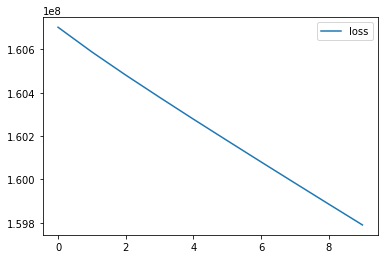

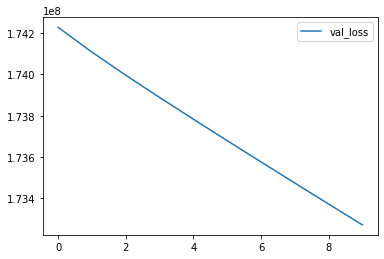

4866

In [25]:
x = np.linspace(0, epochs-1, epochs)
print(model_loss.loss)
print(model_loss.val_loss)
print(x)
plt.plot(x, model_loss.loss, label="loss")
plt.legend()
plt.show()

plt.plot(x, model_loss.val_loss, label="val_loss")
plt.legend()
plt.show()

gc.collect()

## Validation

In [26]:
# Iterate through the dataloader and get predictions for each batch of the test set.
p = iter(vdl)
preds = np.vstack([model(V(next(p))).cpu().data.numpy() for i in range(len(p))])

# Create a pandas DF that shows the Autoencoder MSE vs True Labels
error_nonfraud = np.mean(np.power((X_val-preds),2), axis=1)
"""
p = iter(fdl)
preds = np.vstack([model(V(next(p))).cpu().data.numpy() for i in range(len(p))])
error_fraud = np.mean(np.power((X_train_fraud-preds),2), axis=1)

pd.DataFrame(error_fraud)
"""
error_df = pd.DataFrame(data = {'error':error_nonfraud,'true':y_val})

error_df.groupby('true')['error'].describe().reset_index()

/Users/nicenoize/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


ValueError: Shape of passed values is (18, 2), indices imply (7872, 2)

### ROC_AUC

In [27]:
fpr, tpr, thresholds = roc_curve(error_df.true, error_df.error)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = {})'.format(roc_auc))
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

NameError: name 'error_df' is not defined

In [28]:
temp_df = error_df[error_df['true'] == 0]
threshold = temp_df['error'].mean() + temp_df['error'].std()
print(f'Threshold: {threshold:.3f}')

NameError: name 'error_df' is not defined

### Precision Recall F1-Score

In [29]:
y_pred = [1 if e > threshold else 0 for e in error_df.error.values]
print(classification_report(error_df.true.values,y_pred))

NameError: name 'error_df' is not defined

### Plot Precision Recall

In [30]:
conf_matrix = confusion_matrix(error_df.true, y_pred)

sns.set(font_scale = 1.2)
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, xticklabels=['Not Fraud','Fraud'], yticklabels=['Not Fraud','Fraud'], annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

NameError: name 'error_df' is not defined

### Plot Precision Recall for each thresholds
Changing the threshold from threshold_min to threshold_max.

In [31]:
plt.figure(figsize=(12, 12))
m = []
threshold_min = threshold * 0.99
threshold_max = threshold * 1.01

for thresh in np.linspace(threshold_min, threshold_max):
    y_pred = [1 if e > thresh else 0 for e in error_df.error.values]
    conf_matrix = confusion_matrix(error_df.true, y_pred)
    m.append((conf_matrix,thresh))
    
count = 0
for i in range(3):
    for j in range(3):
        plt.subplot2grid((3, 3), (i, j))
        sns.heatmap(m[count][0], xticklabels=['Not Fraud','Fraud'], yticklabels=['Not Fraud','Fraud'], annot=True, fmt="d");
        plt.title(f"Threshold - {m[count][1]:.3f}")
        plt.ylabel('True class')
        plt.xlabel('Predicted class')
        plt.tight_layout()
        count += 1
plt.show()

NameError: name 'threshold' is not defined

<Figure size 864x864 with 0 Axes>

In [32]:
# Iterate through the dataloader and get predictions for each batch of the test set.
p = iter(tdl)
preds = np.vstack([model(V(next(p))).cpu().data.numpy() for i in range(len(p))])

# Create a pandas DF that shows the Autoencoder MSE vs True Labels
error = np.mean(np.power((X_test-preds),2), axis=1)

In [33]:
def min_max_normalization(x):
    x_min = x.min()
    x_max = x.max()
    x_norm = (x-x_min) / (x_max-x_min)
    return x_norm

# min max normalization
#error_df = pd.DataFrame(data={'isFraud':min_max_normalization(error)})
error_df = pd.DataFrame(data={'isFraud':error})

print("Num data: " + str(len(error_df)))
print("Beyond threshold num data: " + str(len(error_df[error_df['isFraud'] > threshold])))
#error_df[error_df['isFraud'] > threshold]

x_min = 3600000
x_max = 4200000
plt.hlines(threshold, x_min, x_max, "black")
plt.plot(error_df, alpha=0.3)
plt.show()

Num data: 39363


NameError: name 'threshold' is not defined

In [34]:
error_df = pd.DataFrame(data={'isFraud':min_max_normalization(error)})
error_df.head()

,isFraud
SUBJECT_ID,
2,0.499895
4,0.381670
6,0.597499
8,0.577284
9,0.399021


In [35]:
sample_submission['isFraud'] = error_df
sample_submission.to_csv('simple_autoencoder.csv')

# To be continued

# Feature Engineering
## Day/Hour features from TransactionDT

In [36]:
# Making day/hour features. See the kernel below:
# https://www.kaggle.com/c/ieee-fraud-detection/discussion/100400#latest-579480
"""
def make_day_feature(df, offset=0, tname='TransactionDT'):
    # found a good offset is 0.58
    days = df[tname] / (3600*24)        
    encoded_days = np.floor(days-1+offset) % 7
    return encoded_days

def make_hour_feature(df, tname='TransactionDT'):
    hours = df[tname] / (3600)        
    encoded_hours = np.floor(hours) % 24
    return encoded_hours

# check train
print(make_day_feature(train, offset=0.58).value_counts().head(10))
print(make_hour_feature(train).value_counts().head(10))

train['TransactionDay'] = make_day_feature(train, offset=0.58)
train['TransactionHour'] = make_hour_feature(train)
test['TransactionDay'] = make_day_feature(test, offset=0.58)
test['TransactionHour'] = make_hour_feature(test)

"""

"\ndef make_day_feature(df, offset=0, tname='TransactionDT'):\n    # found a good offset is 0.58\n    days = df[tname] / (3600*24)        \n    encoded_days = np.floor(days-1+offset) % 7\n    return encoded_days\n\ndef make_hour_feature(df, tname='TransactionDT'):\n    hours = df[tname] / (3600)        \n    encoded_hours = np.floor(hours) % 24\n    return encoded_hours\n\n# check train\nprint(make_day_feature(train, offset=0.58).value_counts().head(10))\nprint(make_hour_feature(train).value_counts().head(10))\n\ntrain['TransactionDay'] = make_day_feature(train, offset=0.58)\ntrain['TransactionHour'] = make_hour_feature(train)\ntest['TransactionDay'] = make_day_feature(test, offset=0.58)\ntest['TransactionHour'] = make_hour_feature(test)\n\n"

In [37]:
"""
# Delete columns
drop_true = False
if(drop_true):
    drop_col = ['V300', 'V309', 'V111', 'C3', 'V124', 'V106', 'V125', 'V315', 'V134', 'V102', 'V123', 'V316', 'V113', 'V136', 'V305', 'V110', 'V299', 'V289', 'V286', 'V318', 'V103', 'V304', 'V116', 'V298', 'V284', 'V293', 'V137', 'V295', 'V301', 'V104', 'V311', 'V115', 'V109', 'V119', 'V321', 'V114', 'V133', 'V122', 'V319', 'V105', 'V112', 'V118', 'V117', 'V121', 'V108', 'V135', 'V320', 'V303', 'V297', 'V120']
    X_train.drop(drop_col,axis=1, inplace=True)
    X_test.drop(drop_col, axis=1, inplace=True)
    X_train.head()
    
"""

"\n# Delete columns\ndrop_true = False\nif(drop_true):\n    drop_col = ['V300', 'V309', 'V111', 'C3', 'V124', 'V106', 'V125', 'V315', 'V134', 'V102', 'V123', 'V316', 'V113', 'V136', 'V305', 'V110', 'V299', 'V289', 'V286', 'V318', 'V103', 'V304', 'V116', 'V298', 'V284', 'V293', 'V137', 'V295', 'V301', 'V104', 'V311', 'V115', 'V109', 'V119', 'V321', 'V114', 'V133', 'V122', 'V319', 'V105', 'V112', 'V118', 'V117', 'V121', 'V108', 'V135', 'V320', 'V303', 'V297', 'V120']\n    X_train.drop(drop_col,axis=1, inplace=True)\n    X_test.drop(drop_col, axis=1, inplace=True)\n    X_train.head()\n    \n"

In [38]:
"""
correlation_matrix = X_train.corr()
fig = plt.figure(figsize=(12,9))
sns.heatmap(correlation_matrix,vmax=0.8,square = True)

plt.show()

"""

'\ncorrelation_matrix = X_train.corr()\nfig = plt.figure(figsize=(12,9))\nsns.heatmap(correlation_matrix,vmax=0.8,square = True)\n\nplt.show()\n\n'

# Training

DAYS OF RESEARCH BROUGHT ME TO THE CONCLUSION THAT I SHOULD SIMPLY SPECIFY `tree_method='gpu_hist'` IN ORDER TO ACTIVATE GPU (okay jk, took me an hour to figure out, but I wish XGBoost documentation was more clear about that).

In [39]:
"""
from sklearn.cluster import KMeans
KMeans(n_clusters=2).fit(X_train)

clf = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=9,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    missing=-999,
    tree_method='gpu_hist'  # THE MAGICAL PARAMETER
)
"""

"\nfrom sklearn.cluster import KMeans\nKMeans(n_clusters=2).fit(X_train)\n\nclf = xgb.XGBClassifier(\n    n_estimators=500,\n    max_depth=9,\n    learning_rate=0.05,\n    subsample=0.9,\n    colsample_bytree=0.9,\n    missing=-999,\n    tree_method='gpu_hist'  # THE MAGICAL PARAMETER\n)\n"

## KFold and validation

In [40]:
"""
def get_avg_auc_kfold(X_train, y_train, X_test, clf, NFOLDS=2, shuffle=True):
    kf = KFold(n_splits=NFOLDS, shuffle=shuffle)
    y_preds = np.zeros(X_test.shape[0])
    y_oof = np.zeros(X_train.shape[0])
    score = 0
  
    for fold, (tr_idx, val_idx) in enumerate(kf.split(X_train, y_train)):    
        X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
        y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
        clf.fit(X_tr, y_tr)
        y_pred_train = clf.predict_proba(X_vl)[:,1]
        y_oof[val_idx] = y_pred_train
        print("FOLD: ",fold,' AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
        score += roc_auc_score(y_vl, y_pred_train) / NFOLDS
        y_preds+= clf.predict_proba(X_test)[:,1] / NFOLDS
    
        del X_tr, X_vl, y_tr, y_vl
        gc.collect()
    print (">> Avg AUC: ", score)
    return score

executeKFold = False
if(executeKFold):
    print(get_avg_auc_kfold(X_train, y_train, X_test, clf))
    
"""

'\ndef get_avg_auc_kfold(X_train, y_train, X_test, clf, NFOLDS=2, shuffle=True):\n    kf = KFold(n_splits=NFOLDS, shuffle=shuffle)\n    y_preds = np.zeros(X_test.shape[0])\n    y_oof = np.zeros(X_train.shape[0])\n    score = 0\n  \n    for fold, (tr_idx, val_idx) in enumerate(kf.split(X_train, y_train)):    \n        X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]\n        y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]\n        clf.fit(X_tr, y_tr)\n        y_pred_train = clf.predict_proba(X_vl)[:,1]\n        y_oof[val_idx] = y_pred_train\n        print("FOLD: ",fold,\' AUC {}\'.format(roc_auc_score(y_vl, y_pred_train)))\n        score += roc_auc_score(y_vl, y_pred_train) / NFOLDS\n        y_preds+= clf.predict_proba(X_test)[:,1] / NFOLDS\n    \n        del X_tr, X_vl, y_tr, y_vl\n        gc.collect()\n    print (">> Avg AUC: ", score)\n    return score\n\nexecuteKFold = False\nif(executeKFold):\n    print(get_avg_auc_kfold(X_train, y_train, X_test, clf))\n    \

# Train
## training and visualizing all importances of futures

In [41]:
"""
# Training
%time clf.fit(X_train, y_train)

# Get xgBoost importances
importance_dict = {}
for import_type in ['weight', 'gain', 'cover']:
    importance_dict['xgBoost-'+import_type] = clf.get_booster().get_score(importance_type=import_type)
    
# MinMax scale all importances
importance_df = pd.DataFrame(importance_dict).fillna(0)
importance_df = pd.DataFrame(
    preprocessing.MinMaxScaler().fit_transform(importance_df),
    columns=importance_df.columns,
    index=importance_df.index
)

# Create mean column
importance_df['mean'] = importance_df.mean(axis=1)

# Plot the feature importances
importance_df.sort_values('mean').head(50).plot(kind='bar', figsize=(20, 7))

"""

"\n# Training\n%time clf.fit(X_train, y_train)\n\n# Get xgBoost importances\nimportance_dict = {}\nfor import_type in ['weight', 'gain', 'cover']:\n    importance_dict['xgBoost-'+import_type] = clf.get_booster().get_score(importance_type=import_type)\n    \n# MinMax scale all importances\nimportance_df = pd.DataFrame(importance_dict).fillna(0)\nimportance_df = pd.DataFrame(\n    preprocessing.MinMaxScaler().fit_transform(importance_df),\n    columns=importance_df.columns,\n    index=importance_df.index\n)\n\n# Create mean column\nimportance_df['mean'] = importance_df.mean(axis=1)\n\n# Plot the feature importances\nimportance_df.sort_values('mean').head(50).plot(kind='bar', figsize=(20, 7))\n\n"

In [42]:
"""
sample_submission['isFraud'] = clf.predict_proba(X_test)[:,1]
sample_submission.to_csv('simple_xgboost.csv')
"""

"\nsample_submission['isFraud'] = clf.predict_proba(X_test)[:,1]\nsample_submission.to_csv('simple_xgboost.csv')\n"